# Beispiel 3.6

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [6]:
import pandas as pd

werbung = pd.read_csv("./Daten/Werbung.csv").drop(["Unnamed: 0"], axis=1)

werbung.head()
print(werbung.head())

      TV  Radio  Zeitung  Verkauf
0  230.1   37.8     69.2     22.1
1   44.5   39.3     45.1     10.4
2   17.2   45.9     69.3      9.3
3  151.5   41.3     58.5     18.5
4  180.8   10.8     58.4     12.9


In [7]:
with pm.Model() as model_lb:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=100)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    mu = pm.Deterministic("mu", beta_0 + beta_1 * werbung.TV)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=werbung.Verkauf)
    idata_lb = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


/opt/conda/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


In [8]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


/opt/conda/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

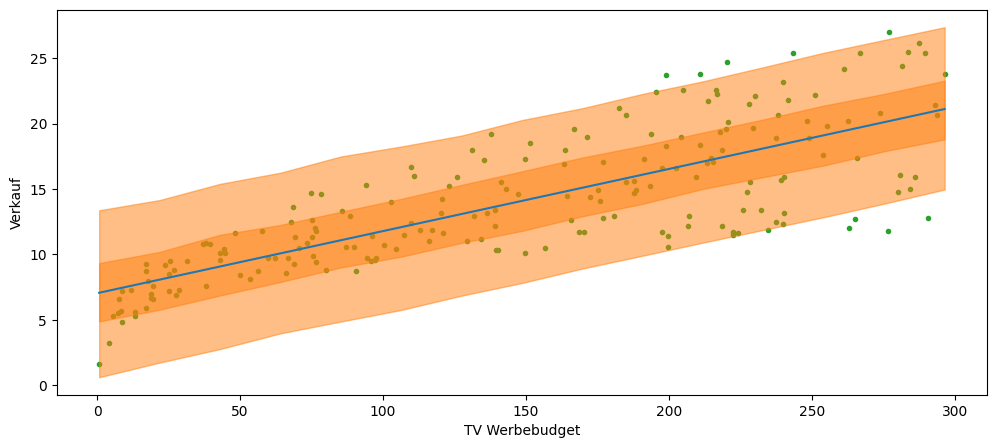

In [14]:
mean_line = idata_lb.posterior["mu"].mean(("chain", "draw"))
TV = np.random.normal(werbung.TV.values, 0.01)
idx = np.argsort(TV)
x = np.linspace(TV.min(), TV.max(), 15)
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(TV[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(werbung.TV, werbung.Verkauf, "C2.", zorder=-3)
ax.plot(werbung.TV[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("TV Werbebudget")
ax.set_ylabel("Verkauf")
plt.savefig("linear_verkauf_posterior_predictive.png")